In [1]:
%cd ..

/sunjinsheng/codebase/cv_codeformer


In [2]:
import os
import cv2
import argparse
import glob
import torch
from PIL import Image
from omegaconf import OmegaConf
from typing import OrderedDict
from torchvision.transforms.functional import normalize
from torchvision import transforms

from src.utils import imwrite, img2tensor, tensor2img
from src.utils.download_util import load_file_from_url
from src.utils.misc import get_device
from src.archs import * # !register architectures
from src.utils.options import dict2str
from src.utils.registry import ARCH_REGISTRY

In [8]:
opts = OmegaConf.load('options/open_images_scene_images_transformer.yaml')
params = opts['first_stage_config']['params']
params

{'ckpt_path': None, 'embed_dim': 256, 'n_embed': 8192, 'ddconfig': {'double_z': False, 'z_channels': 256, 'resolution': 512, 'in_channels': 3, 'out_ch': 3, 'ch': 128, 'ch_mult': [1, 1, 2, 2, 4], 'num_res_blocks': 2, 'attn_resolutions': [16], 'dropout': 0.0}}

In [9]:
model = ARCH_REGISTRY.get('VQModel')
net = model(**params)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------ set up CodeFormer restorer -------------------
net = net.to(device)

Working with z of shape (1, 256, 32, 32) = 262144 dimensions.


In [ ]:
# list(net.state_dict().keys())

In [10]:
ckpt_path = 'weights/vqgan/open-images_8k_vqgan/coco_oi_epoch12.ckpt'
checkpoint = torch.load(ckpt_path)
checkpoint

/tmp/ipykernel_2767/1008756838.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path)


{'epoch': 13,
 'global_step': 2395952,
 'pytorch-lightning_version': '0.9.0',
 'checkpoint_callback_best_model_score': tensor(0.4661, device='cuda:2'),
 'checkpoint_callback_best_model_path': '/export/home/majahn/graph2net/logs/2021-02-18T14-35-10_coco256ddvqae1616256tanh_finetune_oi/checkpoints/epoch=000010.ckpt',
 'optimizer_states': [{'state': {0: {'step': 2395952,
     'exp_avg': tensor([[[[-0.0016, -0.0017, -0.0018],
               [-0.0017, -0.0017, -0.0019],
               [-0.0015, -0.0017, -0.0018]],
     
              [[-0.0013, -0.0013, -0.0014],
               [-0.0013, -0.0013, -0.0014],
               [-0.0011, -0.0011, -0.0013]],
     
              [[-0.0014, -0.0014, -0.0015],
               [-0.0014, -0.0014, -0.0015],
               [-0.0013, -0.0013, -0.0014]]],
     
     
             [[[ 0.0007,  0.0008,  0.0008],
               [ 0.0009,  0.0010,  0.0009],
               [ 0.0009,  0.0010,  0.0009]],
     
              [[ 0.0008,  0.0009,  0.0008],
           

In [18]:
new_sd_state_dict = OrderedDict()
for key in checkpoint['state_dict'].keys():
    if key in net.state_dict().keys():
        new_sd_state_dict[key] = checkpoint['state_dict'][key]

In [20]:
net.load_state_dict(new_sd_state_dict,strict=False)

<All keys matched successfully>

In [21]:

net.eval()
# print(net.state_dict().keys())
set([key.split('.')[0] for key in list(net.state_dict().keys())])

{'decoder', 'encoder', 'post_quant_conv', 'quant_conv', 'quantize'}

Processing: a0040.jpg


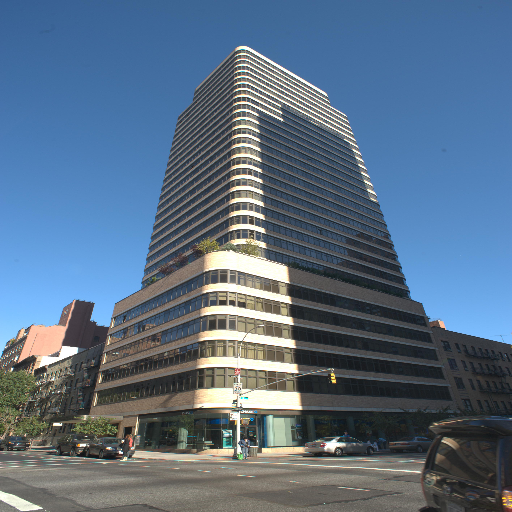

In [37]:
# -------------------- start to processing ---------------------
suffix = '.jpg'
result_root = 'results'
img_path = '/root/wp/data/iharmony4/HAdobe5k/real_images/a0040.jpg'

img_name = os.path.basename(img_path)
basename, ext = os.path.splitext(img_name)
print(f'Processing: {img_name}')
input_face = cv2.imread(img_path)
input_face = cv2.cvtColor(input_face, cv2.COLOR_BGR2RGB)
input_face = cv2.resize(input_face, (512, 512), interpolation=cv2.INTER_LINEAR)
assert input_face.shape[:2] == (512, 512), 'Input resolution must be 512x512 for inpainting.' 
Image.fromarray(input_face)

In [38]:
# input_face = cv2.resize(input_face, (512, 512), interpolation=cv2.INTER_LINEAR)
input_face = img2tensor(input_face / 255., bgr2rgb=True, float32=True)
normalize(input_face, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
input_face = input_face.unsqueeze(0).to(device)

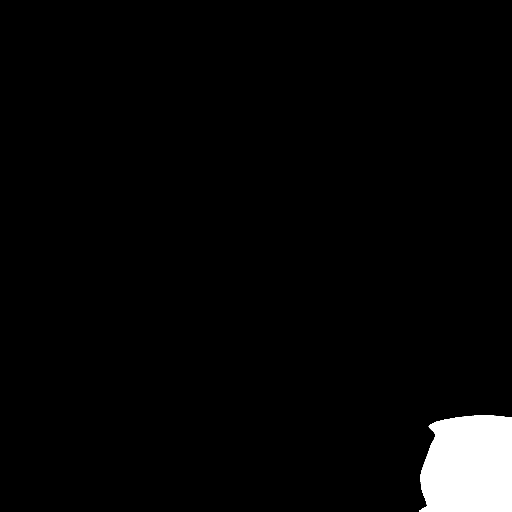

In [39]:
mask_path = "/root/wp/data/iharmony4/HAdobe5k/masks/a0040_1.png"
mask = cv2.imread(mask_path, 0)
mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_LINEAR)
Image.fromarray(mask)

In [40]:
tf = transforms.Compose([
    transforms.ToTensor(),
])
mask = tf(mask)

In [41]:
with torch.no_grad():
    mask = mask.view(1, 1, 512, 512).to(device)
    # w is fixed to 1, adain=False for inpainting
    output_face = net(input_face)[0]
    output_face = (1-mask)*input_face + mask*output_face
    save_face = tensor2img(output_face, rgb2bgr=True, min_max=(-1, 1))

del output_face
torch.cuda.empty_cache()

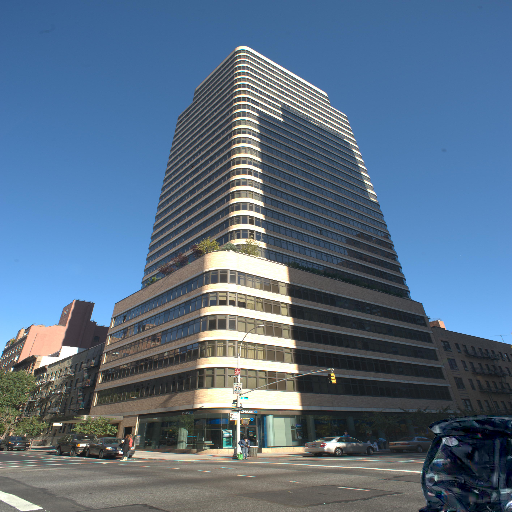

In [42]:
save_face = save_face.astype('uint8')
Image.fromarray(save_face)